In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import datetime
import sqlite3
from IPython.core.display import HTML
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


C:\Users\asiddhpu.ORADEV\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#utility functions
#timeSplit function will seperate data in 70-30%
def timeSplit(data):
    noOfRows=data.shape[0]
    seperatePoint= int(noOfRows * 0.70)
    train_review_x=data.iloc[:seperatePoint,:]
    test_review_x=data.iloc[seperatePoint:,:]
    train_label_y=data_sample['Score'].iloc[:seperatePoint]
    test_label_y=data_sample['Score'].iloc[seperatePoint:]
    return train_review_x,test_review_x,train_label_y,test_label_y

In [3]:
#connection to already cleaned data which we have done in previous assignments and selection of data time wise 
#so we can easily do time based splitting
conn = sqlite3.connect('finalData.sqlite')
data_sample = pd.read_sql_query("select * from REVIEWS order by Time",conn)

In [4]:
#changing class label to numeric from character
data_sample["Score"]= data_sample["Score"].replace({'p':1,'n':0})

In [5]:

train_review_x,test_review_x,train_label_y,test_label_y=timeSplit(data_sample)
# print("train_review_x :: ",train_review_x.shape)
# print("test_review_x :: ",test_review_x.shape)
# print("train_label_y :: ",train_label_y.shape)
# print("test_label_y :: ",test_label_y.shape)


In [6]:
#BoW of cleaned text column in clean data
count_vect = CountVectorizer() #in scikit-learn
bow_counts_train_x = count_vect.fit_transform(train_review_x['CleanedText'])
bow_counts_test_x = count_vect.transform(test_review_x['CleanedText'])
# bow_counts_train_y = count_vect.fit_transform(train_label_y['Score'])
# bow_counts_test_y = count_vect.fit_transform(test_label_y['Score'])

<h1><b>Bernouli BOW</b></h1>

In [7]:
#10-fold cross validation for finding optimal alpha
cv_scores = [-1]
listNumber=[]
def rangfunc(start,stop,step):    
    
    r = start
    optimal_alpha=-1
    while r < stop:
        listNumber.append(r)
        classDemo = BernoulliNB(alpha=r) 
        scores = cross_val_score(classDemo, bow_counts_train_x, train_label_y, cv=10, scoring='accuracy')
        scores_mean=scores.mean()
        if(scores_mean>max(cv_scores)):
            optimal_alpha=r
        cv_scores.append(scores_mean)
        r += step
    return optimal_alpha
v=rangfunc(0.001,10,0.1)
print("optimal_alpha",v)


optimal_alpha 0.001


In [8]:
cv_scores.pop(0)

-1

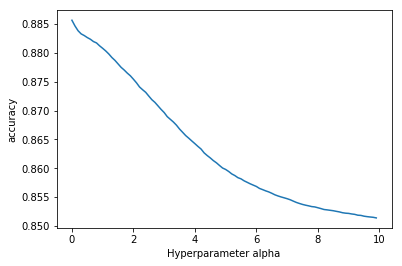

In [9]:
#graph of hyperparameter alpha versus accuracy
plt.plot(listNumber, cv_scores)

# for xy in zip(listNumber, np.round(cv_scores,3)):
#     plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyperparameter alpha')
plt.ylabel('accuracy')
plt.show()

<b>as the hyper parameter value increasing accuracy is decreasing.</b>

In [10]:
actualDemo = BernoulliNB(alpha=0.001) 
actualDemo.fit(bow_counts_train_x,np.array(train_label_y))

BernoulliNB(alpha=0.001, binarize=0.0, class_prior=None, fit_prior=True)

In [11]:
bow_counts_train_x.shape

(254919, 94896)

In [12]:
bow_counts_test_x.shape

(109252, 94896)

In [13]:
predicted= actualDemo.predict(bow_counts_test_x)

In [14]:
accuracy_score(test_label_y, predicted)

0.8807985208508768

<b>accuracy_score for bag of words with alpha 0.001  is 0.874</b>

In [15]:
f1_score(test_label_y, predicted)

0.9282949471145641

<b>f1 score for bag of words is 0.923</b>

In [16]:
print("precesion for BOW with alpha 0.001 is",precision_score(test_label_y, predicted, average="macro"))
print("Recall for BOW with alpha 0.001 is",recall_score(test_label_y, predicted, average="macro"))  

precesion for BOW with alpha 0.001 is 0.7959718987147268
Recall for BOW with alpha 0.001 is 0.7800749443528718


In [17]:
confusion_matrix(test_label_y, predicted)

array([[11931,  7150],
       [ 5873, 84298]], dtype=int64)

In [18]:
confusion_matrix(test_label_y, predicted).ravel()

array([11931,  7150,  5873, 84298], dtype=int64)

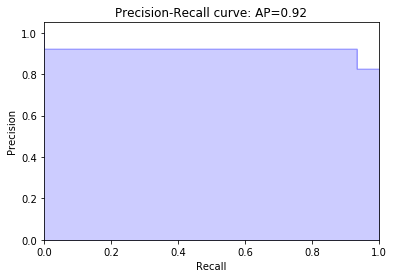

In [19]:
average_precision = average_precision_score(test_label_y, predicted)
precision, recall, _ = precision_recall_curve(test_label_y, predicted)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()


In [20]:
def important_features(vectorizer,classifier,n=20):
        class_labels = classifier.classes_
        feature_names =vectorizer.get_feature_names()
        topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
        topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
        print("Important words in negative reviews")
        for coef, feat in topn_class1:
            print(class_labels[0], coef, feat)
        print("-----------------------------------------")
        print("Important words in positive reviews")
        for coef, feat in topn_class2:
            print(class_labels[1], coef, feat) 

<b>Important features in BOW.</b>

In [21]:
important_features(count_vect,actualDemo, n=20)

Important words in negative reviews
0 14212.0 tast
0 13957.0 like
0 11298.0 product
0 9807.0 one
0 9183.0 would
0 8750.0 tri
0 8100.0 flavor
0 8048.0 good
0 7584.0 buy
0 7171.0 get
0 6871.0 use
0 6560.0 dont
0 6096.0 even
0 5981.0 order
0 5318.0 much
0 5280.0 make
0 5012.0 realli
0 4994.0 time
0 4867.0 love
0 4745.0 amazon
-----------------------------------------
Important words in positive reviews
1 65877.0 like
1 64408.0 tast
1 60613.0 love
1 60171.0 good
1 59088.0 great
1 51578.0 flavor
1 49633.0 one
1 48724.0 use
1 46578.0 tri
1 45059.0 product
1 41686.0 make
1 39725.0 get
1 32146.0 buy
1 31902.0 time
1 30539.0 would
1 30491.0 best
1 29958.0 find
1 29744.0 realli
1 28701.0 price
1 28445.0 amazon


<h1><b>MultinomialNB BOW</b></h1>

In [22]:
#10-fold cross validation for finding optimal alpha
cv_scores = [-1]
listNumber=[]
def rangfunc(start,stop,step):    
    
    r = start
    optimal_alpha=-1
    while r < stop:
        listNumber.append(r)
        classDemo = MultinomialNB(alpha=r) 
        scores = cross_val_score(classDemo, bow_counts_train_x, train_label_y, cv=10, scoring='accuracy')
        scores_mean=scores.mean()
        if(scores_mean>max(cv_scores)):
            optimal_alpha=r
        cv_scores.append(scores_mean)
        r += step
    return optimal_alpha
v=rangfunc(0.001,10,0.1)
print("optimal_alpha MultinomialNB BOW ",v)


optimal_alpha MultinomialNB BOW  1.7010000000000005


In [23]:
cv_scores.pop(0)


-1

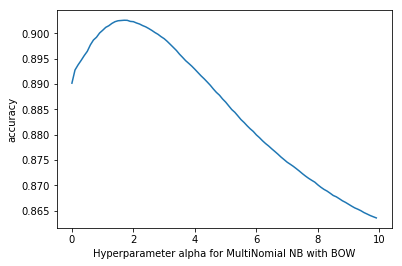

In [24]:
#graph of hyperparameter alpha versus accuracy
plt.plot(listNumber, cv_scores)

# for xy in zip(listNumber, np.round(cv_scores,3)):
#     plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyperparameter alpha for MultiNomial NB with BOW')
plt.ylabel('accuracy')
plt.show()

In [25]:
actualDemoMulti = MultinomialNB(alpha=1.7010000000000005) 
actualDemoMulti.fit(bow_counts_train_x,np.array(train_label_y))

MultinomialNB(alpha=1.7010000000000005, class_prior=None, fit_prior=True)

In [26]:
predicted= actualDemoMulti.predict(bow_counts_test_x)

In [27]:
accuracy_score(test_label_y, predicted)

0.8975487862922418

<b>Accuracy for Multinomial NB with BOW is 0.897</b>

In [28]:
f1_score(test_label_y, predicted)

0.93946228359105

<b>F1 score for Multinomial NB with BOW is 0.939</b>

In [30]:
print("precesion for MultinomialNB with BOW with alpha 1.701 is",precision_score(test_label_y, predicted, average="macro"))
print("Recall for MultinomialNB with BOW with alpha 1.701 is",recall_score(test_label_y, predicted, average="macro"))  

precesion for MultinomialNB with BOW with alpha 1.701 is 0.8441660249874109
Recall for MultinomialNB with BOW with alpha 1.701 is 0.7753064915876857


In [31]:
confusion_matrix(test_label_y, predicted)

array([[11209,  7872],
       [ 3321, 86850]], dtype=int64)

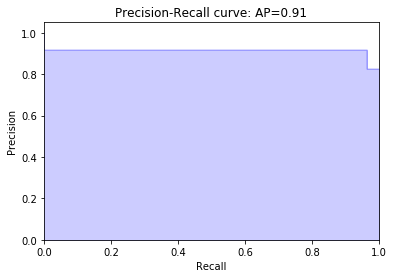

In [32]:
average_precision = average_precision_score(test_label_y, predicted)
precision, recall, _ = precision_recall_curve(test_label_y, predicted)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()


In [33]:
important_features(count_vect,actualDemoMulti, n=20)

Important words in negative reviews
0 23109.0 tast
0 21409.0 like
0 18046.0 product
0 13780.0 one
0 13082.0 flavor
0 11845.0 would
0 11813.0 tri
0 10045.0 good
0 9791.0 use
0 9787.0 coffe
0 9073.0 get
0 9041.0 buy
0 8532.0 order
0 8077.0 food
0 7946.0 tea
0 7772.0 dont
0 7321.0 box
0 7292.0 even
0 6617.0 amazon
0 6577.0 make
-----------------------------------------
Important words in positive reviews
1 96237.0 like
1 89224.0 tast
1 78068.0 good
1 76209.0 flavor
1 74535.0 love
1 72709.0 great
1 71468.0 use
1 67627.0 one
1 61617.0 product
1 61238.0 tea
1 60101.0 tri
1 53535.0 make
1 53403.0 coffe
1 50347.0 get
1 44202.0 food
1 38311.0 time
1 37777.0 would
1 37598.0 buy
1 36865.0 eat
1 36376.0 realli


<b>Naive Bayes with TF-IDF</b>

In [34]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train_x = tf_idf_vect.fit_transform(train_review_x['CleanedText'])
tfidf_test_x = tf_idf_vect.transform(test_review_x['CleanedText'])
#final_tf_idf = tf_idf_vect.fit_transform(data_sample['CleanedText'])


In [21]:
#train_review_xt,test_review_xt,train_label_yt,test_label_yt=timeSplit(final_tf_idf)

In [35]:
#10-fold cross validation for finding optimal alpha(tf-idf)
cv_scores_tfidf = [-1]
listNumber_tfidf=[]
def rangfunc(start,stop,step):    
    
    r = start
    optimal_alpha_tfidf=-1
    while r < stop:
        listNumber_tfidf.append(r)
        classDemotfidf = BernoulliNB(alpha=r) 
        scores_tfidf = cross_val_score(classDemotfidf, tfidf_train_x, train_label_y, cv=10, scoring='accuracy')
        scores_mean_tfidf=scores_tfidf.mean()
        if(scores_mean_tfidf>max(cv_scores_tfidf)):
            optimal_alpha_tfidf=r
        cv_scores_tfidf.append(scores_mean_tfidf)
        r += step
    return optimal_alpha_tfidf
opt_v=rangfunc(0.001,10,0.1)
print("optimal_alpha for tf-idf",opt_v)

optimal_alpha for tf-idf 0.001


In [36]:
cv_scores_tfidf.pop(0)
#cv_scores_tfidf

-1

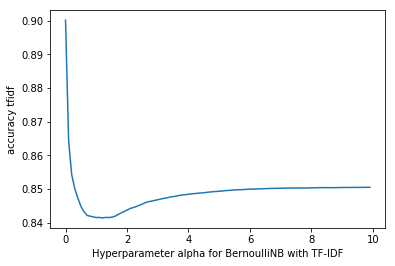

In [38]:
#graph of hyperparameter alpha versus accuracy tf-idf
plt.plot(listNumber_tfidf, cv_scores_tfidf)

# for xy in zip(listNumber, np.round(cv_scores,3)):
#     plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyperparameter alpha for BernoulliNB with TF-IDF')
plt.ylabel('accuracy tfidf')
plt.show()

<b>in starting with alpha value accuracy is very high but suddenly with the alpha increasing accuracy decreased and then become nearly stable.</b>

In [39]:
actualDemotfidf = BernoulliNB(alpha=0.001) 
actualDemotfidf.fit(tfidf_train_x,np.array(train_label_y))

BernoulliNB(alpha=0.001, binarize=0.0, class_prior=None, fit_prior=True)

In [40]:
predicted_tfidf= actualDemotfidf.predict(tfidf_test_x)

In [41]:
accuracy_score(test_label_y, predicted_tfidf)

0.8830410427269066

<b>accuracy_score for TF-iDF with alpha 0.001 is 0.890</b>

In [42]:
f1_score(test_label_y, predicted_tfidf)

0.9330426854190464

<b>f1 score for TF-iDF is 0.935</b>


In [43]:
confusion_matrix(test_label_y, predicted_tfidf)

array([[ 7444, 11637],
       [ 1141, 89030]], dtype=int64)

In [45]:
print("precesion for TF-IDF with alpha 0.001 is",precision_score(test_label_y, predicted_tfidf, average="macro"))
print("Recall for TF-IDF with alpha 0.001 is",recall_score(test_label_y, predicted_tfidf, average="macro"))  

precesion for TF-IDF with alpha 0.001 is 0.8757474066150008
Recall for TF-IDF with alpha 0.001 is 0.6887362839864313


In [46]:
confusion_matrix(test_label_y, predicted_tfidf).ravel()

array([ 7444, 11637,  1141, 89030], dtype=int64)

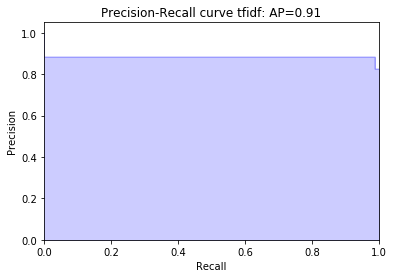

In [47]:
average_precision_tfidf = average_precision_score(test_label_y, predicted_tfidf)
precision_tfidf, recall_tfidf, _ = precision_recall_curve(test_label_y, predicted_tfidf)

plt.step(recall_tfidf, precision_tfidf, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_tfidf, precision_tfidf, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve tfidf: AP={0:0.2f}'.format(
          average_precision))
plt.show()


<b>Important features in TF-IDF.</b>

In [48]:
important_features(tf_idf_vect,actualDemotfidf, n=20)

Important words in negative reviews
0 14212.0 tast
0 13957.0 like
0 11298.0 product
0 9807.0 one
0 9183.0 would
0 8750.0 tri
0 8100.0 flavor
0 8048.0 good
0 7584.0 buy
0 7171.0 get
0 6871.0 use
0 6560.0 dont
0 6096.0 even
0 5981.0 order
0 5318.0 much
0 5280.0 make
0 5012.0 realli
0 4994.0 time
0 4867.0 love
0 4745.0 amazon
-----------------------------------------
Important words in positive reviews
1 65877.0 like
1 64408.0 tast
1 60613.0 love
1 60171.0 good
1 59088.0 great
1 51578.0 flavor
1 49633.0 one
1 48724.0 use
1 46578.0 tri
1 45059.0 product
1 41686.0 make
1 39725.0 get
1 32146.0 buy
1 31902.0 time
1 30539.0 would
1 30491.0 best
1 29958.0 find
1 29744.0 realli
1 28701.0 price
1 28445.0 amazon


<h1><b>TF-IDF with MultiNomial</b></h1>

In [49]:
#10-fold cross validation for finding optimal alpha(tf-idf)
cv_scores_tfidf = [-1]
listNumber_tfidf=[]
def rangfunc(start,stop,step):    
    
    r = start
    optimal_alpha_tfidf=-1
    while r < stop:
        listNumber_tfidf.append(r)
        classDemotfidf = MultinomialNB(alpha=r) 
        scores_tfidf = cross_val_score(classDemotfidf, tfidf_train_x, train_label_y, cv=10, scoring='accuracy')
        scores_mean_tfidf=scores_tfidf.mean()
        if(scores_mean_tfidf>max(cv_scores_tfidf)):
            optimal_alpha_tfidf=r
        cv_scores_tfidf.append(scores_mean_tfidf)
        r += step
    return optimal_alpha_tfidf
opt_v=rangfunc(0.001,10,0.1)
print("optimal_alpha for tf-idf MultinomialNB",opt_v)

optimal_alpha for tf-idf MultinomialNB 0.001


In [50]:
cv_scores_tfidf.pop(0)

-1

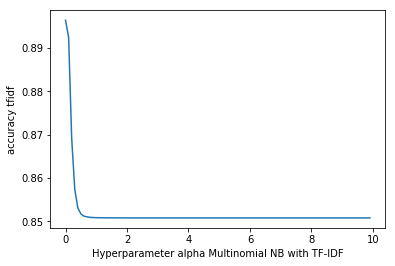

In [51]:
#graph of hyperparameter alpha(Multinomial NB) versus accuracy tf-idf 
plt.plot(listNumber_tfidf, cv_scores_tfidf)

# for xy in zip(listNumber, np.round(cv_scores,3)):
#     plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyperparameter alpha Multinomial NB with TF-IDF')
plt.ylabel('accuracy tfidf')
plt.show()

<b>As the alpha increases accuracy decreases and after one level it became stable.</b>

In [52]:
Multinomialtfidf = MultinomialNB(alpha=0.001) 
Multinomialtfidf.fit(tfidf_train_x,np.array(train_label_y))

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [53]:
predicted_multi_tfidf= Multinomialtfidf.predict(tfidf_test_x)

In [54]:
accuracy_score(test_label_y, predicted_multi_tfidf)

0.8761304140885293

In [55]:
f1_score(test_label_y, predicted_multi_tfidf)

0.9295688152176741

In [56]:
confusion_matrix(test_label_y, predicted_multi_tfidf)

array([[ 6413, 12668],
       [  865, 89306]], dtype=int64)

In [57]:
print("precesion for Multinomial NB TF-IDF with alpha 0.001 is",precision_score(test_label_y, predicted_multi_tfidf, average="macro"))
print("Recall for Multinomial NBTF-IDF with alpha 0.001 is",recall_score(test_label_y, predicted_multi_tfidf, average="macro"))

precesion for Multinomial NB TF-IDF with alpha 0.001 is 0.8784604614446414
Recall for Multinomial NBTF-IDF with alpha 0.001 is 0.6632503057588436


In [58]:
confusion_matrix(test_label_y, predicted_multi_tfidf).ravel()

array([ 6413, 12668,   865, 89306], dtype=int64)

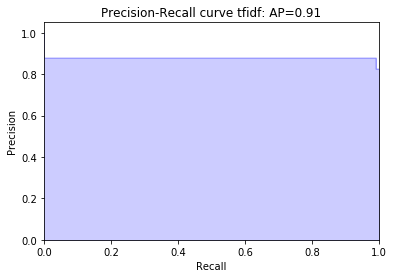

In [59]:
average_precision_tfidf = average_precision_score(test_label_y, predicted_multi_tfidf)
precision_tfidf, recall_tfidf, _ = precision_recall_curve(test_label_y, predicted_multi_tfidf)

plt.step(recall_tfidf, precision_tfidf, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_tfidf, precision_tfidf, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve tfidf: AP={0:0.2f}'.format(
          average_precision))
plt.show()


In [60]:
important_features(tf_idf_vect,Multinomialtfidf, n=20)

Important words in negative reviews
0 702.5294369750587 tast
0 611.5409165277913 like
0 584.5851597983036 product
0 434.65716925607023 would
0 423.7815435723929 flavor
0 422.2659644262646 coffe
0 417.09782234229004 one
0 374.89223930491465 tri
0 365.6047308135317 buy
0 364.26960891611515 order
0 333.20703149737835 box
0 331.0171620293959 tea
0 312.21158773786703 good
0 311.5595158110192 disappoint
0 305.62962439323456 dont
0 304.5876943574383 get
0 290.47512708684934 use
0 281.167342850309 even
0 274.0170828160202 food
0 267.2620531593663 bag
-----------------------------------------
Important words in positive reviews
1 2994.3081056968003 great
1 2973.909100686317 love
1 2830.22714140017 tast
1 2817.226967950082 tea
1 2815.719257462234 like
1 2798.574630018744 good
1 2634.5876137785017 flavor
1 2563.5225473578985 coffe
1 2381.5295699405483 use
1 2347.2407939345608 product
1 2175.4504586399185 one
1 2033.7859436818476 tri
1 1918.1847714703808 make
1 1792.479975673457 get
1 1704.3142503

<b>Summary</b>

<img src="files/Naive_Bayes_Summary.jpg">